In [1]:
import os
import sys
import time
import numpy as np
from numpy.linalg import inv
import joblib
import matplotlib.pyplot as plt
import torch

# External libs used by the notebook logic
import cvxpy as cp  # noqa: F401  (imported to match notebook environment)
from neuromancer.system import Node, System
from neuromancer.problem import Problem
from neuromancer.loss import PenaltyLoss
from neuromancer.modules import blocks


In [2]:
# Resolve project paths (repo root assumed to be parent of this script's CWD)
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
src_path = os.path.join(project_root, 'src')
if src_path not in sys.path:
    sys.path.append(src_path)

figures_dir = os.path.join(project_root, 'figures')
os.makedirs(figures_dir, exist_ok=True)

# Local imports from the project
import models  # type: ignore
import helper  # type: ignore

# -----------------------------
# Load matrices, model, scalers
# -----------------------------
matrix_C = False

A = np.load(os.path.join(project_root, 'data', f'A_C_{matrix_C}.npy'))
B = np.load(os.path.join(project_root, 'data', f'B_C_{matrix_C}.npy'))
C = np.load(os.path.join(project_root, 'data', f'C_C_{matrix_C}.npy'))

nz, nu = B.shape
ny = C.shape[0]

# disturbance matrix F and dimension nd
F = np.eye(ny)
nd = F.shape[1]

# Block-diagonalize A using helper
T_real, A_block = helper.ident.real_block_diagonalize(A)

# Transform A to check
A_transformed = inv(T_real) @ A @ T_real
print('Close to block diagonal?', np.allclose(A_block, A_transformed, atol=1e-6))

# Backtransform A_block to verify it equals A
A_backtransformed = T_real @ A_block @ inv(T_real)
print('Backtransformation equals original A?', np.allclose(A, A_backtransformed, atol=1e-6))

# Apply similarity transform to A, B, C
A = A_block
B = inv(T_real) @ B
C = C @ T_real

# -----------------------------
# Build Koopman model components
# -----------------------------
layers = [40, 80, 120]
layers_dec = [120, 80, 40]

# Output encoder f_y
f_y = blocks.MLP(
    ny,
    nz,
    bias=True,
    linear_map=torch.nn.Linear,
    nonlin=torch.nn.ReLU,
    hsizes=layers,
)
encode_Y0 = Node(f_y, ['Y0'], ['x'], name='encoder_Y0')
encode_Y = Node(f_y, ['Y'], ['x_latent'], name='encoder_Y')

# Input encoder f_u representing B in linear system
f_u = torch.nn.Linear(nu, nz, bias=False)
encode_U = Node(f_u, ['U'], ['u_latent'], name='encoder_U')

# State decoder f_y_inv
if not matrix_C:
    f_y_inv = blocks.MLP(
        nz,
        ny,
        bias=True,
        linear_map=torch.nn.Linear,
        nonlin=torch.nn.ELU,
        hsizes=layers_dec,
    )
elif matrix_C:
    f_y_inv = torch.nn.Linear(nz, ny, bias=False)
else:
    raise ValueError('matrix_C must be boolean')

decode_y = Node(f_y_inv, ['x'], ['yhat'], name='decoder_y')

# Linear map K for latent dynamics
K = torch.nn.Linear(nz, nz, bias=False)

# Symbolic Koopman model with control inputs
Koopman = Node(helper.PredictionWControl(K), ['x', 'u_latent'], ['x'], name='K')
dynamics_model = System([Koopman], name='Koopman', nsteps=1)

nodes = [encode_Y0, encode_Y, encode_U, dynamics_model, decode_y]
loss = PenaltyLoss([], constraints=[])
problem = Problem(nodes, loss)

problem.load_state_dict(
    torch.load(os.path.join(project_root, 'data', f'model_C_{matrix_C}.pth')),
    strict=False,
)

# -----------------------------
# Load scalers and plant model
# -----------------------------
scaler = joblib.load(os.path.join(project_root, 'data', 'scaler.pkl'))
scalerU = joblib.load(os.path.join(project_root, 'data', 'scalerU.pkl'))


Models imported succesfully
Helper imported succesfully
Close to block diagonal? True
Backtransformation equals original A? True


In [3]:
# Plant model: use full nonlinear CSTR series with recycle for simulation
CSTR = models.CSTRSeriesRecycle()

# Helper conversion utilities
def get_x(y: np.ndarray) -> np.ndarray:
    x = problem.nodes[0]({'Y0': torch.from_numpy(y).float()})
    return x['x'].detach().numpy().reshape(1, -1).T

def get_y(x: np.ndarray) -> np.ndarray:
    y = problem.nodes[4]({'x': torch.from_numpy(x.T).float()})
    return y['yhat'].detach().numpy().reshape(1, -1)

def get_y_vector(x: np.ndarray) -> np.ndarray:
    y = problem.nodes[4]({'x': torch.from_numpy(x.T).float()})
    return y['yhat'].detach().numpy()

# -----------------------------
# Observer - Kalman filter setup
# -----------------------------
loaded_setup = joblib.load(os.path.join(os.getcwd(), 'sim_setup.pkl'))

y_start = loaded_setup['y_start']
y_start_ns = loaded_setup.get('y_start_ns')
reference_ns = loaded_setup.get('reference_ns')
y_setpoint = loaded_setup['reference'][:, 0]
u_previous = loaded_setup['u_previous']
u_previous_ns = loaded_setup.get('u_previous_ns')

z_est_ = np.hstack(((inv(T_real) @ get_x(y_start)).T, np.zeros((1, nd))))
P0 = loaded_setup['P0']
Q = loaded_setup['Q']  # process noise
R = loaded_setup['R']  # measurement noise

A_ = np.block([
    [A, np.zeros((nz, nd))],
    [np.zeros((nd, nz)), np.eye(nd)],
])
B_ = np.vstack([
    B,
    np.zeros((nd, nu)),
])

EKF = helper.EKF(A_, B_, z_est_, P0, problem, Q, R, 8, T_real)
# EKF = helper.EKF_C(A_, B_, C, z_est_, P0, problem, Q, Rm, 2, T_real)

# -----------------------------
# Target calculation
# -----------------------------
target_estimation = helper.TaylorTargetEstimation(A, B)

J = helper.evaluate_jacobian(
    problem.nodes[4],
    torch.from_numpy(T_real @ z_est_[0, :nz]).float(),
) @ T_real

z_s, y_s, _ = target_estimation.get_target(
    z_est_[:, nz:], y_setpoint, get_y(T_real @ z_est_[0, :nz]), z_est_[0, :nz], J
)
print(target_estimation.te.status)
print('Optimal y:', scaler.inverse_transform(y_s.reshape(1, -1)))
print('Desired y:', scaler.inverse_transform(y_setpoint.reshape(1, -1)))
print('Optimal u:', scalerU.inverse_transform(target_estimation.u_s.value.reshape(1, -1)))
z_ref = z_s


Set parameter Username
Set parameter LicenseID to value 2631450
Academic license - for non-commercial use only - expires 2026-03-05
optimal
Optimal y: [[ 51.06953233 293.8171218   33.3188175  292.19314046  22.26165122
   30.89361897   1.6378966    2.16966378]]
Desired y: [[ 51.49817787 293.83413299  33.16119253 292.02597578  22.1340168
   30.86691182   1.64727237   2.51846765]]
Optimal u: [[1.37134471e-04 7.66162127e-05 2.90473014e+02 2.90732510e+02]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


In [4]:

# -----------------------------
# MPC problem formulation
# -----------------------------
Qy = loaded_setup['Qy']
J = helper.evaluate_jacobian(
    problem.nodes[4],
    torch.from_numpy(T_real @ z_s).float(),
) @ T_real
Qz = J.T @ Qy @ J
Qz_psd = Qz + 1e-8 * np.eye(Qz.shape[0])

mpc = helper.TaylorMPC(A, B)
mpc.build_problem(Qz_psd)
u_opt = mpc.get_u_optimal(
    z_est_[0, :nz], z_est_[:, nz:], u_previous, z_ref, get_y(T_real @ z_s), z_s, J
)
print(u_opt)
print(mpc.mpc.status)


[ 0.74796513 -0.83139776 -0.90208731 -0.86798437]
optimal


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


In [5]:

# -----------------------------
# Closed-loop simulation
# -----------------------------
sim_time = loaded_setup['sim_time']
Ts = 1
z_sim = np.zeros((nz + nd, sim_time + 1))
y_sim = np.zeros((ny, sim_time + 1))
u_sim = np.zeros((nu, sim_time))
ys_sim = np.zeros((ny, sim_time + 1))
zs_sim = np.zeros((nz, sim_time + 1))
us_sim = np.zeros((nu, sim_time + 1))

total_time_target = 0.0
total_time_mpc = 0.0

start_time_target = time.time()
z_s, y_s, _ = target_estimation.get_target(
    z_est_[:, nz:], y_setpoint, get_y(T_real @ z_s), z_s, J
)
end_time_target = time.time()
total_time_target += end_time_target - start_time_target

y_sim_descaled = np.zeros((ny, sim_time + 1))
u_sim_descaled = np.zeros((nu, sim_time))
y_pred = np.zeros((ny, sim_time))

z_sim[:, 0] = z_est_.flatten()
y_sim[:, 0] = y_start.flatten()
ys_sim[:, 0] = y_s
zs_sim[:, 0] = z_s
u_prev = target_estimation.u_s.value
u_sim_descaled[:, 0] = scalerU.inverse_transform(u_sim[:, 0].reshape(1, -1))[0]
y_sim_descaled[:, 0] = scaler.inverse_transform(y_sim[:, 0].reshape(1, -1))[0]

for k in range(sim_time):
    y_setpoint = loaded_setup['reference'][:, k]
    idx_prev = max(k - 1, 0)

    # target update (T2): linearize at previous target zs_sim[:, k]
    J = helper.evaluate_jacobian(
        problem.nodes[4],
        torch.from_numpy(T_real @ zs_sim[:, idx_prev]).float(),
    ) @ T_real
    start_time_target = time.time()
    zs_sim[:, k], ys_sim[:, k], _ = target_estimation.get_target(
        z_sim[nz:, k], 
        y_setpoint, 
        get_y(T_real @ zs_sim[:, idx_prev]), 
        zs_sim[:, idx_prev], 
        J
    )
    end_time_target = time.time()
    y_pred[:, k] = J@z_sim[:nz, k] + get_y(T_real @ zs_sim[:, idx_prev]) - J @ zs_sim[:, idx_prev]
    total_time_target += end_time_target - start_time_target

    # T2/D2: for MPC, linearize at the previous target zs_sim[:, k-1] (use k=0 fallback)
    # J_prev = helper.evaluate_jacobian(
    #     problem.nodes[4],
    #     torch.from_numpy(T_real @ zs_sim[:, idx_prev]).float(),
    # ) @ T_real
    # J = J_prev

    # if k > 0:
    Qz = J.T @ Qy @ J
    Qz_psd = Qz + 1e-8 * np.eye(Qz.shape[0])
    mpc.build_problem(Qz_psd)

    start_time_mpc = time.time()
    u_opt = mpc.get_u_optimal(
        z_sim[:nz, k],
        z_sim[nz:, k],
        u_prev,
        zs_sim[:, k],
        get_y(T_real @ zs_sim[:, idx_prev]),
        zs_sim[:, idx_prev],
        J,
    )
    end_time_mpc = time.time()
    total_time_mpc += end_time_mpc - start_time_mpc

    u_sim[:, k] = u_opt
    u_sim_descaled[:, k] = scalerU.inverse_transform(u_sim[:, k].reshape(1, -1))[0]

    # simulate plant in physical space
    y_sim_descaled[:, k + 1] = CSTR.step(
        y_sim_descaled[:, k], u_sim_descaled[:, k].reshape(1, -1), Ts
    )
    y_sim[:, k + 1] = scaler.transform(y_sim_descaled[:, k + 1].reshape(1, -1))[0]

    # state estimation
    z_sim[:, k + 1] = EKF.step(u_sim[:, k], y_sim[:, k + 1]).flatten()

    u_prev = u_sim[:, k]

print(f'Total time spent in target estimation: {total_time_target:.4f} seconds')
print(f'Total time spent in MPC solve: {total_time_mpc:.4f} seconds')


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

Total time spent in target estimation: 2.1794 seconds
Total time spent in MPC solve: 57.2427 seconds


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


In [6]:
z_sim[:, k].shape

(30,)

Closed-loop objective function value: 15.218600019847838
  - State tracking term: 14.079753852007238
  - Input increment term: 1.1388461678405921


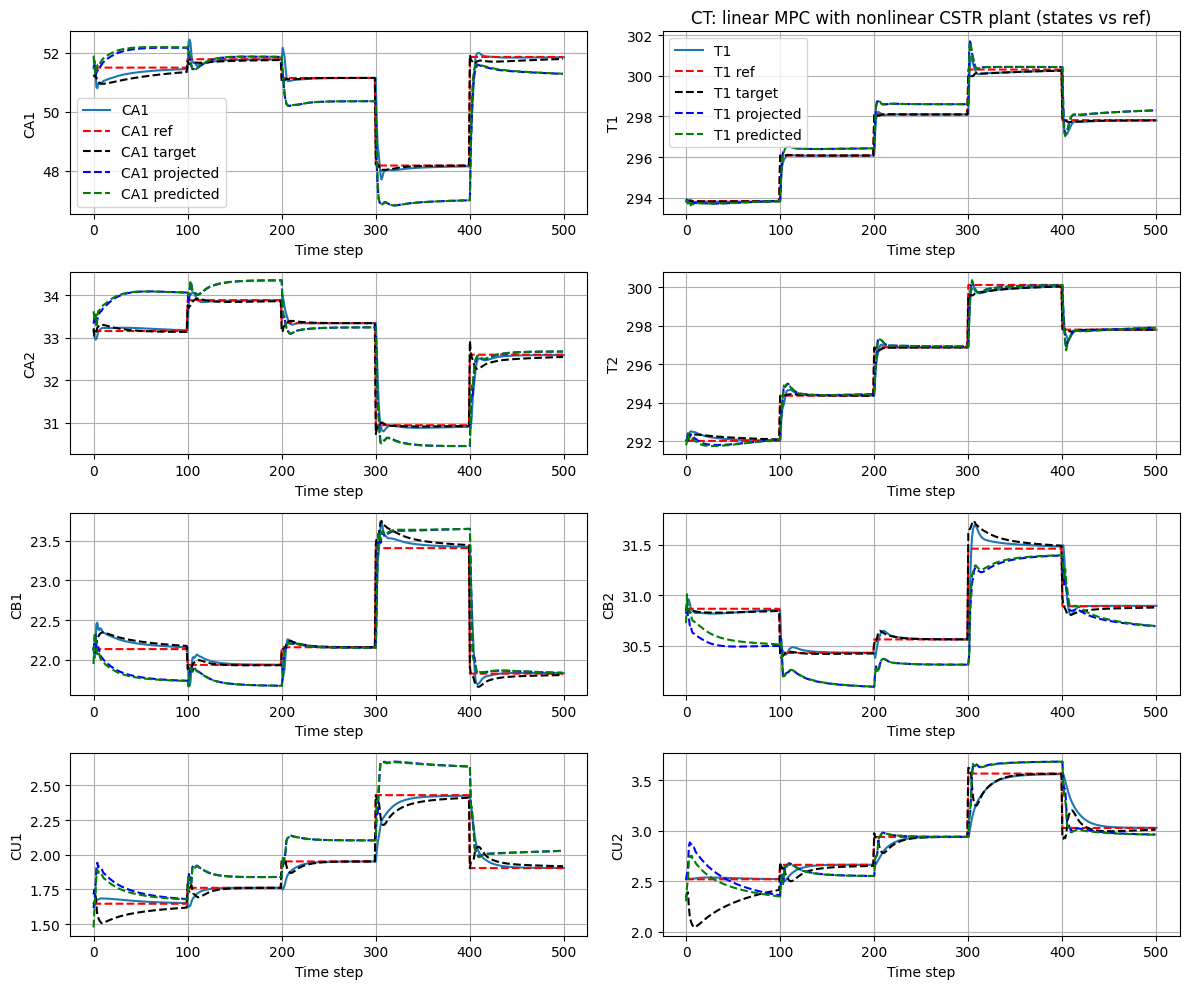

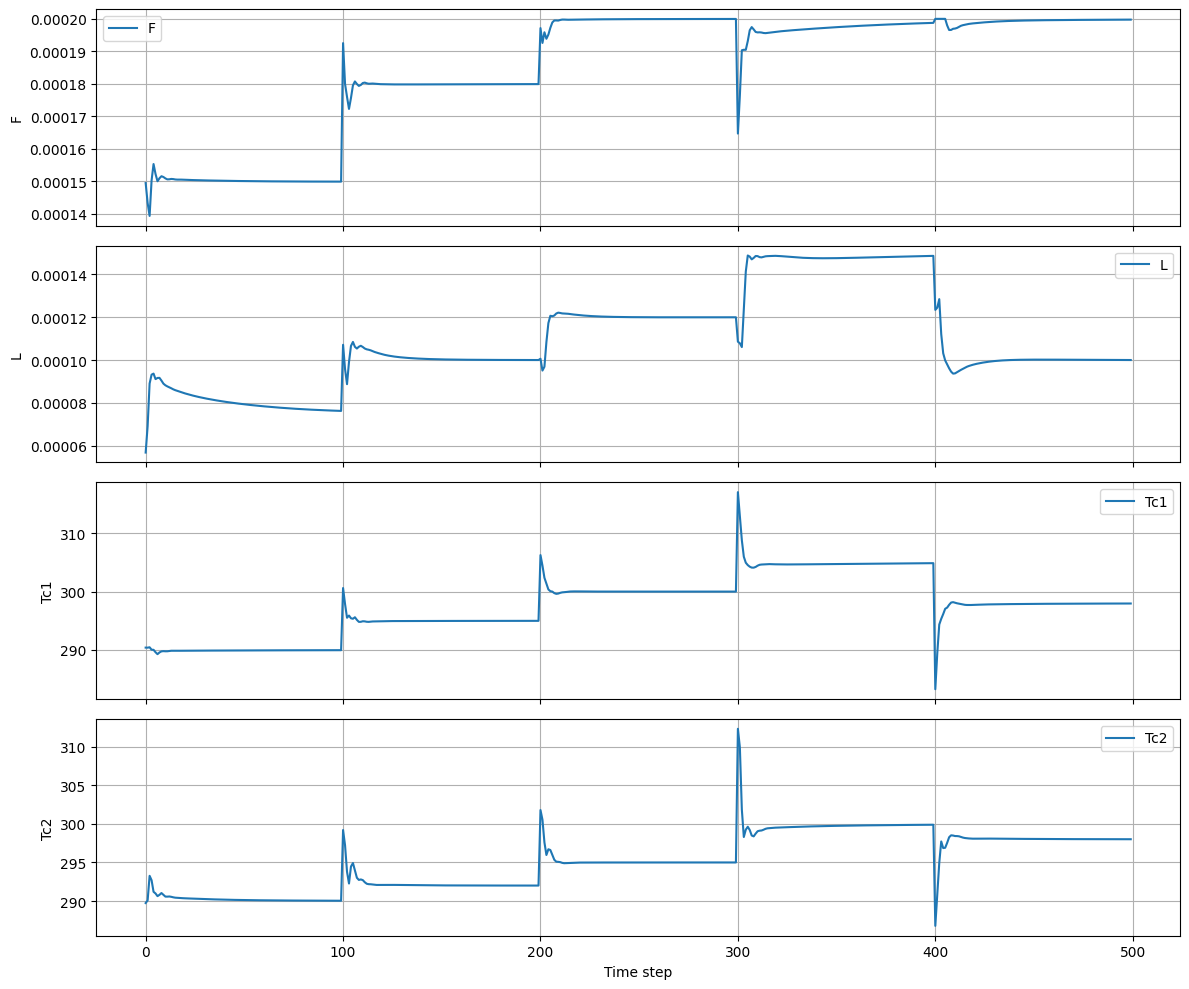

In [9]:
reference = loaded_setup['reference']
# Compute objective in non-scaled units (like NMPC.py)
Qu = loaded_setup['Qu']
Qy = loaded_setup['Qy']
objective_value = 0.0
state_error_cost = 0.0
control_increment_cost = 0.0
for k in range(sim_time):
    if reference_ns is not None:
        y_ref_k = reference[:, k]
    else:
        y_ref_k = scaler.inverse_transform(loaded_setup['reference'][:, k].reshape(1, -1))[0]
    y_diff = y_sim[:, k] - y_ref_k
    prev_u = u_sim[:, k - 1] if k > 0 else u_sim[:, k]
    u_diff = u_sim[:, k] - prev_u
    y_term = float(y_diff.T @ Qy @ y_diff)
    u_term = float(u_diff.T @ Qu @ u_diff)
    state_error_cost += y_term
    control_increment_cost += u_term
    objective_value += y_term + u_term

print(f"Closed-loop objective function value: {objective_value}")
print(f"  - State tracking term: {state_error_cost}")
print(f"  - Input increment term: {control_increment_cost}")



# Plots saved to figures/ in non-scaled domain (8 states, 4 inputs)
fig = plt.figure(figsize=(12, 10))
names = ['CA1','T1','CA2','T2','CB1','CB2','CU1','CU2']
n_steps = sim_time
ys_sim_ns = scaler.inverse_transform(ys_sim.T).T
y_projected = get_y_vector(T_real @ z_sim[:nz,:])
y_projected_ns = scaler.inverse_transform(y_projected).T
y_pred_ns = scaler.inverse_transform(y_pred.T).T
for i in range(min(8, ny)):
    plt.subplot(4, 2, i+1)
    plt.plot(y_sim_descaled[i, :], label=names[i] if i < len(names) else f'y{i}')
    if reference_ns is not None:
        plt.plot(reference_ns[i, :n_steps+1], 'r--', label=f'{names[i]} ref' if i < len(names) else f'y{i} ref')
        plt.plot(ys_sim_ns[i, :n_steps], 'k--', label=f'{names[i]} target')
    plt.plot(y_projected_ns[i, :n_steps], 'b--', label=f'{names[i]} projected')
    plt.plot(y_pred_ns[i, :n_steps], 'g--', label=f'{names[i]} predicted')
    plt.xlabel('Time step')
    plt.ylabel(names[i] if i < len(names) else f'y{i}')
    plt.grid(True)
    if i in (0,1):
        plt.legend()
    if i == 1:
        plt.title('CT: linear MPC with nonlinear CSTR plant (states vs ref)')
plt.tight_layout()


fig_inputs, axs = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
input_names = ['F', 'L', 'Tc1', 'Tc2']
for i in range(4):
    axs[i].plot(u_sim_descaled[i, :], label=input_names[i])
    axs[i].set_ylabel(input_names[i])
    axs[i].grid(True)
    axs[i].legend()
axs[-1].set_xlabel('Time step')
fig_inputs.tight_layout()



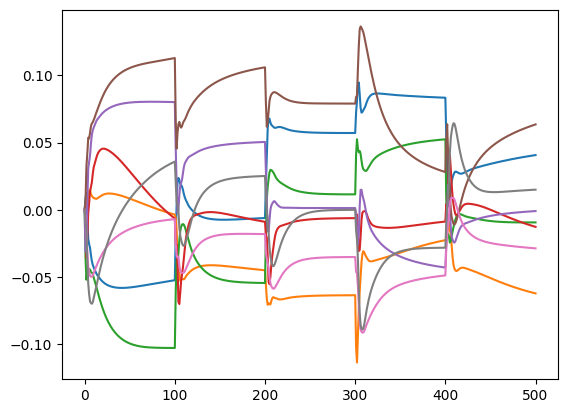

In [8]:
plt.plot(z_sim[nz:,:].T)